# importation les libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, LabelBinarizer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor,
                              AdaBoostRegressor,
                              GradientBoostingRegressor,
                              ExtraTreesRegressor,
                              BaggingRegressor)
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.preprocessing import Imputer
import lightgbm as lgb
from sklearn.model_selection import KFold
from collections import defaultdict
%matplotlib inline

/Users/nguyenkhacbaoanh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [32]:
def MAPE(y_true, y_pred):
    # assuré que les parameters entrés sont 1D array
    y_true = np.array(y_true).reshape(1, -1)[0]
    y_pred = np.array(y_pred).reshape(1, -1)[0]
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [37]:
# fonction de calculation le performance du model: 1 - MAPE
def accuracy_score(y_true, y_pred):
    y_true = np.array(y_true).reshape(1, -1)[0]
    y_pred = np.array(y_pred).reshape(1, -1)[0]
    mape = np.mean(np.abs(y_true - y_pred) / y_true)
    accuracy = 1. - mape
    return accuracy

# Data source

## Data Origin

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv")
DATA_ZIP_DIR_PATH = os.path.join(DATA_DIR, "Data_cars.csv.zip")

In [5]:
if not os.path.exists(DATA_DIR_PATH):
    !unzip "${DATA_ZIP_DIR_PATH}"

data_car = pd.read_csv(DATA_DIR_PATH)

data_car.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [6]:
data_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 9 columns):
Price          166695 non-null float64
Make           166695 non-null object
Model          166695 non-null object
Model_year     166695 non-null int64
Mileage        166695 non-null object
Fuel           166695 non-null object
Gearbox        166695 non-null object
Online         166695 non-null object
Description    166695 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 11.4+ MB


# Preprocessing

## Function

- En premier temps, nous utilisons les fonctions qui permets rapidement de transformer et/ou extraire des features

In [7]:
def online_clean(df):
    """
    Traitement les champs en type de string et en datatime format et le convertir en type datetime
    """
    datetime_format = "%d/%m/%Y à %Hh%M"
    df.Online = [datetime.strptime(d, datetime_format) for d in df.Online.values]
    return df

def mileage_clean(df):
    """
    convertir le champ kilometrage de string vers float
    """
    df.Mileage = [float(m.split(' ')[0]) for m in df.Mileage.values]
    return df

def descriptions_clean(df):
    """
    extraire le champe de descriptions:
    - version
    - puissance fiscale
    - le nombre de la porte
    - les options
    - la couleur
    """
    regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
    version = []
    puissance_fiscale = []
    portes = []
    options = []
    couleur = []
    for i in range(df.shape[0]):
        match = re.search(regex_pattern, df.Description[i])
        version.append(match.group(2))
        puissance_fiscale.append(match.group(3))
        portes.append(match.group(4))
        options.append(match.group(5))
        couleur.append(match.group(6))
    df["version"] = list(map(str.lower, version))
    df["puissance_fiscale"] = puissance_fiscale
    df["portes"] = portes
    df["options"] = options
    df["couleur"] = list(map(str.lower, couleur))
    del df["Description"]
    return df

def cylindre_cv_extra(df):
    """
    a partir de colone `version`, on extrait le nombre de:
    - cylindré
    - cv
    """
    regex_cyclindre = "\d+[\.,]\d+"
    regex_cv = "\s+\d{1,3}\s?"
    cylindre = []
    cheveaux = []
    for i in range(df.version.shape[0]):
        if df.version[i] == 'ii allurehdifap2.0150cv':
            df.version[i] = 'ii allurehdifap 2.0 150cv'
        #print(i, data_car_preprocessed.version[i])
        text = df.version[i]
        # supprimer les nombres du kilogmetrage dans le text
        text = re.sub("\d+[\.,]\d+km", "", text)
        text = re.sub("(159.226|76.538|87.480|71.000)", "", text)
        cl = re.findall(regex_cyclindre, text)
        text = re.sub(regex_cyclindre, "", text)
        # supprimer les nombres du porte dans text
        text = re.sub("\d+p", "", text)
        cv = re.findall(regex_cv, text)
        if len(cl) == 0:
            #print("None")
            cylindre.append(np.nan)
        else:
            #print("More 2")
            cylindre.append(float(cl[0].strip().replace(",", ".")))

        if len(cv) == 0:
            cheveaux.append(np.nan)
        else:
            cheveaux.append(int(cv[0].strip()))
        #cylindre.append(re.findall(regex, data_car_preprocessed.version[i])[0])
    # print(len(cv), len(cylindre), df.shape)
    df["cylindre"] = cylindre
    df["cv"] = cheveaux
    return df

def price_log_transformation(df):
    df["log_price"] = np.log(df.Price.values)
    #del df["Price"]
    return df

def car_age(df):
    """
    new feature pour l'age de la voiture
    """
    df["age"] = [int(df.loc[i,"Online"].year) - int(df.loc[i, "Model_year"]) for i in range(df.shape[0])]
    return df

# en raison que les models machine learning ont besoin de type en Integer ou Float
def categorical_variables(df):
    del df["options"]
    categorical_v = ["Make", "Model", "Fuel", "Gearbox", "couleur"]
    df[categorical_v] = df[categorical_v].apply(LabelEncoder().fit_transform)
    return df

def preprocessing(data, preprocessors=None):
    df = data.copy(deep=True)
    if preprocessors is not None:
        for preprocessor in preprocessors:
            df = preprocessor(df)
        return df
    else:
        return df

In [8]:
data = preprocessing(data_car, [online_clean, \
                                mileage_clean, \
                                descriptions_clean, \
                                cylindre_cv_extra, \
                                car_age,
                                price_log_transformation, \
                                categorical_variables])

data.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,puissance_fiscale,portes,couleur,cylindre,cv,age,log_price
0,11220.0,70,46,2014,94341.0,3,1,2018-07-06 03:47:00,1.6 hdi fap 92ch business 5p,4,5.0,881,1.6,92.0,4,9.325453
1,57526.0,13,814,2015,39051.0,3,0,2018-04-03 16:41:00,(f16) xdrive30d 258 m sport bva8,16,5.0,2194,NaN,258.0,3,10.959992
2,80379.0,7,635,2014,75381.0,5,0,2018-07-30 01:55:00,iii avant 4.0 tfsi 560 quattro tiptronic,47,5.0,4957,4.0,560.0,4,11.294508
3,2830.0,34,462,2007,92282.0,5,1,2018-07-09 14:12:00,1.3 70 fun,5,3.0,4089,1.3,70.0,11,7.948032
4,12925.0,32,739,2018,10.0,5,1,2018-05-19 03:52:00,ii sw 1.4 95 pop,5,5.0,1258,1.4,95.0,0,9.466919


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166695 entries, 0 to 166694
Data columns (total 16 columns):
Price                166695 non-null float64
Make                 166695 non-null int64
Model                166695 non-null int64
Model_year           166695 non-null int64
Mileage              166695 non-null float64
Fuel                 166695 non-null int64
Gearbox              166695 non-null int64
Online               166695 non-null datetime64[ns]
version              166695 non-null object
puissance_fiscale    166695 non-null object
portes               166695 non-null object
couleur              166695 non-null int64
cylindre             136619 non-null float64
cv                   158458 non-null float64
age                  166695 non-null int64
log_price            166695 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(7), object(3)
memory usage: 20.3+ MB


In [10]:
data[["puissance_fiscale", "portes"]] = data[["puissance_fiscale", "portes"]].apply(pd.to_numeric)
#test = data[["spuissance_fiscale", "portes"]].apply(pd.to_numeric)
#data[test["portes"].isna()]

- Dans la data origin, le nombre de porte sont en chiffre, donc qu'on pourrais les traiter en numérique catégorie
- La prochaine étape, il y a des features externes qui sont récupéré par le scrapping, dont le port est présenté en chain de caractère. Dans ce cas la, il nous faut d'ajouter la colone `portes` dans la fonction `category_variable()`

## Imputation missing value

### Using Mean Imputation

- La simple moyenne de résoudre les valeurs manquantes dans la dataset est d'utiliser le fonction Imputer avec les stratégie comme: `mean`, `median`, `most_frequent` etc (comme les codes au-dessous)

from sklearn.preprocessing import Imputer
imp = Imputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)

- Nous allons utiliser cette moyenne afin de remplir les valeurs manquantes de `portes` colonne avec le stratégie `most_frequent`.

### Imputer les portes manquantes en stratégie: most_frequent

In [11]:
port_imp = Imputer(missing_values=np.nan, strategy='most_frequent')
data["portes"] = port_imp.fit_transform(data["portes"].values.reshape(-1,1)).reshape(1, -1)[0]

In [12]:
data.isnull().sum()

Price                    0
Make                     0
Model                    0
Model_year               0
Mileage                  0
Fuel                     0
Gearbox                  0
Online                   0
version                  0
puissance_fiscale        0
portes                   0
couleur                  0
cylindre             30076
cv                    8237
age                      0
log_price                0
dtype: int64

### Using linear regression

- As we know that there are a high correlation between number of cv - number of cylindre and price, it means that the higher of cv or of cylindre and the higher car's price.
 
- So we decide to use linear regression to fulfill all missing values

In [13]:
missing_v_feature = ["cylindre", "cv"]
for f in missing_v_feature:
    # les prix qui ont les cylindre ou cv manquant
    missing_data_price = data.loc[data[f].isnull().values, "Price"].values.reshape(-1,1)
    # les index de ces prix
    missing_data_index = data.loc[data[f].isnull().values, "Price"].index.values
    # le dataframe qui ont pas les null sur la colonne de cylindré ou cv, qui va être utilisé pour le train
    dt = data.loc[data[f].notnull(), ["Price", f]]

    m = LinearRegression()
    # training le model linear regressor avec X=prix et y=cylindré ou y=cv
    m.fit(X = dt["Price"].values.reshape(-1,1), y = dt[f].values.reshape(-1,1))
    # prédire sur le nombre de cv ou cylindré en ulisant le prix
    missing_data_pred = m.predict(missing_data_price)
    # remplir les valeurs manquants par ce qui est prédit dans le model linear regressor
    data[f][missing_data_index] = missing_data_pred.reshape(1, -1)[0]

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
data.isnull().sum()

Price                0
Make                 0
Model                0
Model_year           0
Mileage              0
Fuel                 0
Gearbox              0
Online               0
version              0
puissance_fiscale    0
portes               0
couleur              0
cylindre             0
cv                   0
age                  0
log_price            0
dtype: int64

- All's right. il n'en plus les valeurs manquant dans la dataset

## Data preparation

- Definir les features applicable dans le model machine learning et le target (label)

In [15]:
features = ['Make', 'Model', 'Model_year', 'Mileage', 'Fuel', 'Gearbox', 'puissance_fiscale', 'portes', 'couleur', 'age', 'cylindre', 'cv']
target = ["log_price"]

In [17]:
target = data[target]
data = data[features]

In [18]:
print("dataset a {} features et {} samples".format(data.shape[1], data.shape[0]))

dataset a 12 features et 166695 samples


- Spliter les données en train et test set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((133356, 12), (33339, 12), (133356, 1), (33339, 1))

### Metric function

- On definier le metric: le moyen d'absolu des pourcentage d'erreur
- Ce métrique nous permet de savoir combien le pourcentage d'erreur sur chaque sample que le model prédit

### Naive Approche

- Utilise le naif approche pour voir le résultat de prédiction de prix sans appliquer l'apprentissage

In [40]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_train, y_train)
y_pred = dr.predict(X_test)
print("-----"*10)
print("MAPE: {:.2f} %".format(MAPE(np.exp(y_test.values), np.exp(y_pred)) * 100))
print("-----"*10)
print("Performance du model: {:.2f} %".format(100 - MAPE(np.exp(y_test.values), np.exp(y_pred)) * 100))

DummyRegressor(constant=None, quantile=None, strategy='mean')

--------------------------------------------------
MAPE: 100.98 %
--------------------------------------------------
Performance du model: -0.98 %


- Comme on a vu que le MAPE est supérieur à 100 %, c'est à dire `DummyRegressor` est trompé plus 100% dans la prédiction.

## Model `Random forest` appliqué

- En choissant aléatoire ce model parce que son connu dans la machine learning et aussi qui est utilisé beaucoup dans la prédiction de label en nummérique continue.

### Model RandomForest sans hyperparameter

In [41]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

### Features d'importance

<Figure size 1152x576 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances')

<BarContainer object of 12 artists>

([<matplotlib.axis.YTick at 0x1a25a58320>,
 <a list of 12 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

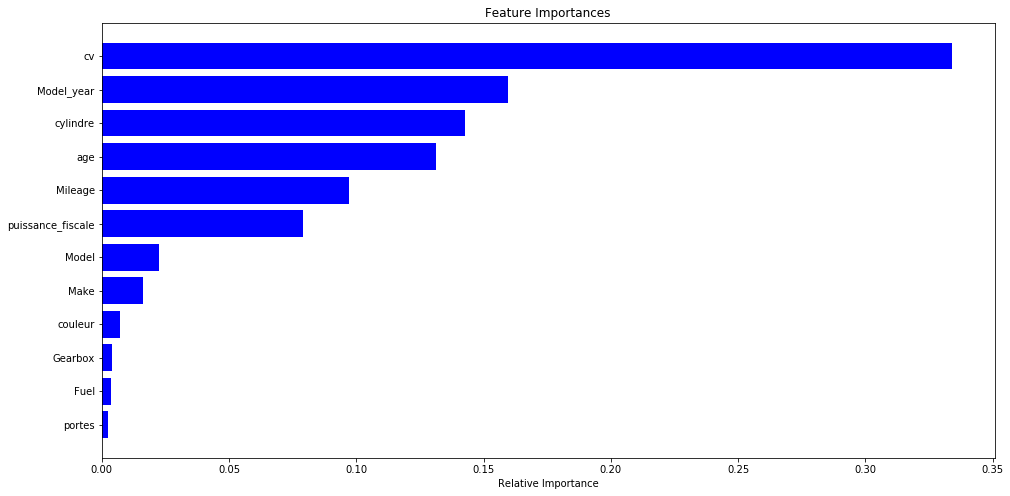

In [42]:
features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
#plt.show()

In [44]:
#X_test_imp = imp.transform(X_test)
y_pred = rfr.predict(X_test)
print("-----"*10)
print("MAPE: {:.2f} %".format(MAPE(np.exp(y_test.values.reshape(1, -1)[0]), np.exp(y_pred)) * 100))
print("-----"*10)

--------------------------------------------------
MAPE: 14.77 %
--------------------------------------------------


In [45]:
np.mean(np.abs(np.exp(y_test.values.reshape(1, -1)[0]) - np.exp(y_pred))/np.exp(y_test.values.reshape(1, -1)[0]))

0.1477206640584618

Sans Hyperparameter sur le model `Randomforest`

- En premier temps, j'utilise `Imputer`avec `mean` stratégie pour imputer les valeurs manquantes:
    - MAPE = 0.17 = 17%
- En deuxième temps, après d'extraction des nouveaux features: le nombre de cheveaux (`cv`) & de cylindré (`cylindre`), l'utilisation de `LinearRegressor` afin d'imputer les deux features manquantes grâce à ses fortes corrélation avec le prix:
    - MAPE = 0.1435 = 14.35%
- En changeant `random_state` lors de spliter la data, le MAPE est 7.07%. Donc le model est très variété ou le model sans hyperparameter n'est pas capable générerer sur les nouveaux datasets.

### Remarque: Le model est sur-apprentissage
- le model n'est pas stable, c'est à dire, il n'est pas capable de générer sur les nouvelles données.
- Afin de savoir, comment se passe-t-il, re-lancer le `randomforest` sans précise le random_state, la prédiction ou autrement dire, le MAPE est parfois est mauvais résultat: plus 100% de MAPE

### Utilisation de `Cross Validation` afin de tester le stabilisation du model

- Une autre moyenne pour tester le model en utilisant le cross validation

In [49]:
%%time
scores = []
mapes = []

cv = KFold(n_splits=20, shuffle=False)

for train_index, val_index in cv.split(X_train):

    X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                            X_train.iloc[val_index, :], \
                                            y_train.values[train_index], y_train.values[val_index]
    # model
    rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
    # fit
    rf_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_cv.predict(X_val)
    # add score
    scores.append(accuracy_score(np.exp(y_val), np.exp(y_val_pred)))
    # metric mape
    mapes.append(MAPE(np.exp(y_val.reshape(1, -1)[0]), np.exp(y_val_pred)))

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_j

CPU times: user 3min 25s, sys: 4.45 s, total: 3min 30s
Wall time: 1min 8s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


(0, 1)

Text(0, 0.5, 'scores')

Text(0.5, 0, 'Fold')

Text(0.5, 1.0, 'Score of Cross Validation with 10 Folder on Random Forest')

Text(0, 0.5, 'MAPE')

Text(0.5, 0, 'Fold')

(0, 1)

Text(0.5, 1.0, 'MAPE of Cross Validation with 10 Folder on Random Forest')

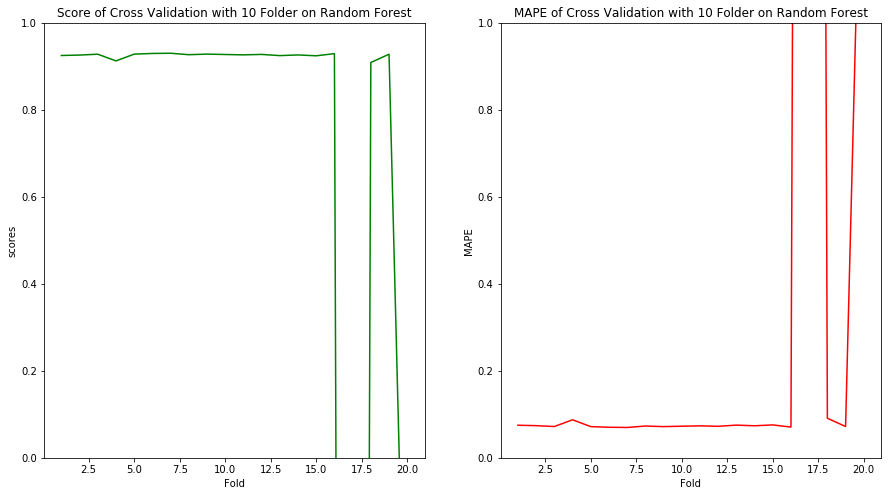

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax = ax.flatten()
ax[0].plot(range(1,21,1), scores, 'g-')
ax[0].set_ylim([0,1])
ax[0].set_ylabel("scores")
ax[0].set_xlabel("Fold")
ax[0].set_title("Score of Cross Validation with 10 Folder on Random Forest")
ax[1].plot(range(1,21,1), mapes, 'r-')
ax[1].set_ylabel("MAPE")
ax[1].set_xlabel("Fold")
ax[1].set_ylim([0,1])
ax[1].set_title("MAPE of Cross Validation with 10 Folder on Random Forest")
plt.show()

- le model a eu le résultat étrange car en deux dernier folds, il y une chute énormément
=> analist les erreurs, explorer le fold particulère, le model particulier pour un model par example

## Comparaison multiples models

In [52]:
%%time
models = [
    ("RandomForest", RandomForestRegressor()),
    ("AdaBoost", AdaBoostRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("ExtraTreesEnsemble", ExtraTreesRegressor()),
    ("Bagging", BaggingRegressor()),
    ("Lasso", Lasso()),
    ("Ridge", Ridge()),
    ("DecisionTree", DecisionTreeRegressor()),
    ("ExtraTree", ExtraTreeRegressor())
]

scores = defaultdict(list)
mapes = defaultdict(list)

cv = KFold(n_splits=5, shuffle=False)

for name, model in models:
    for train_index, val_index in cv.split(X_train):

        X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                                X_train.iloc[val_index, :], \
                                                y_train.values[train_index], y_train.values[val_index]
        # model
        # rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
        # fit
        model.fit(X_train_cv, y_train_cv)
        y_val_pred = model.predict(X_val)
        # add score
        scores[name].append(accuracy_score(np.exp(y_val), np.exp(y_val_pred)))
        # metric mape
        mapes[name].append(MAPE(np.exp(y_val.reshape(1, -1)[0]), np.exp(y_val_pred)))
    

CPU times: user 4min 15s, sys: 6.22 s, total: 4min 22s
Wall time: 2min 55s


Text(0.5, 0, 'Number of Fold')

Text(0, 0.5, 'Score')

(0, 1)

Text(0.5, 1.0, 'Score of Cross Validation with 10 Folder on Multiple Models')

Text(0.5, 0, 'Number of Fold')

Text(0, 0.5, 'Mape')

(0, 1)

Text(0.5, 1.0, 'Mape of Cross Validation with 10 Folder on Multiple Models')

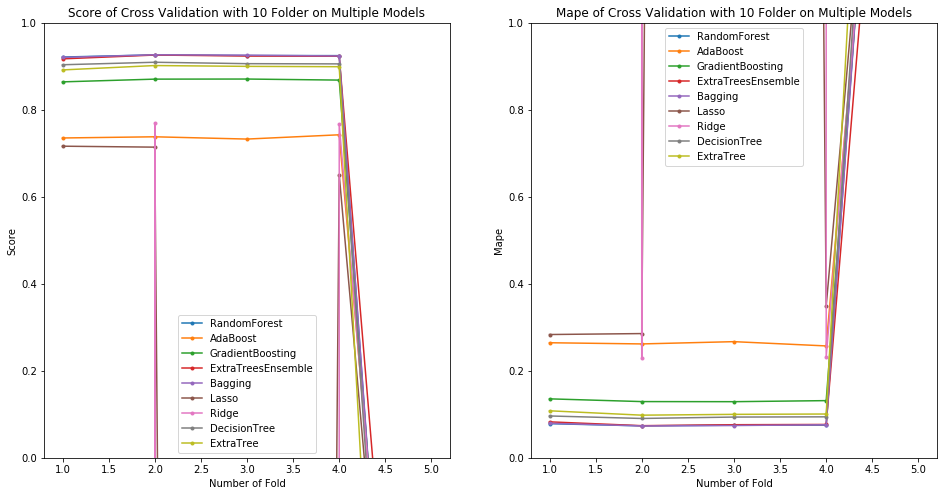

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax = ax.flatten()
ax[0].set_xlabel("Number of Fold")
ax[0].set_ylabel("Score")
ax[0].set_ylim([0,1])
ax[0].set_title("Score of Cross Validation with 10 Folder on Multiple Models")
for k, v in scores.items():
    ax[0].plot(range(1, len(v) + 1), v, '.-', label=k)
ax[0].legend()

ax[1].set_xlabel("Number of Fold")
ax[1].set_ylabel("Mape")
ax[1].set_ylim([0,1])
ax[1].set_title("Mape of Cross Validation with 10 Folder on Multiple Models")
for k, v in mapes.items():
    ax[1].plot(range(1, len(v) + 1), v, '.-', label=k)
ax[1].legend()

plt.show()

In [40]:
for i, m in mapes.items():
    print(i, m)

RandomForest [0.08605599045159483, 0.07852743376743623, 3.15285978111941, 0.07912016666783823, 0.07397128954693594]
AdaBoost [0.44915827980881656, 0.2926629459844507, 1.8693392200542798, 0.29723646692925565, 0.27709748456802297]
GradientBoosting [0.17183793194737124, 0.13538863577608318, 2.925068615037187, 0.13508924275193335, 0.13016470715969936]
ExtraTreesEnsemble [0.10311403870231843, 0.08163422054123111, 2.7741793270694624, 0.08125088197756157, 0.07637170209439313]
Bagging [0.08685079122836019, 0.07985963181402235, 3.1218028614623283, 0.07916542971826497, 0.07410322702546383]
Lasso [0.428411722959461, 0.3672208647157402, 2.972330525833691, 0.2891700178985819, 0.2805389096324802]
Ridge [0.35578881638583626, 3.0771479865782077e+40, 2.9098657581249756, 0.2348878055180928, 4.446183977949428e+16]
DecisionTree [0.10275885052156236, 0.09865110677945868, 3.247754128728448, 0.09578157901030263, 0.09264332540838219]
ExtraTree [0.10872894639325398, 0.10694886369524233, 4.595232935407186, 0.10

<BarContainer object of 9 artists>

(0, 1)

<BarContainer object of 9 artists>

(0, 1)

Text(0, 0.5, 'Score')

Text(0, 0.5, 'MAPE')

Text(0.5, 0, 'Model')

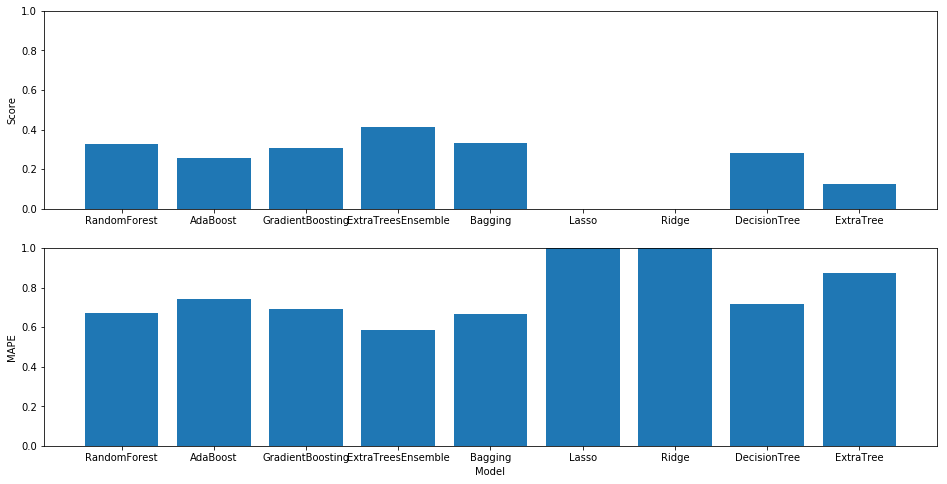

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
ax = ax.flatten()
for a, k in zip(ax, [scores, mapes]):
    m_k = k.keys()
    m_v = [np.mean(v) for v in k.values()]
    a.bar(m_k, m_v)
    a.set_ylim(0,1)

ax[0].set_ylabel("Score")
ax[1].set_ylabel("MAPE")
ax[1].set_xlabel("Model")
#plt.show()

- le résultat disant que l'algorithm `ExtraTreesEnsemble` est le meilleur model

## Hyperparameter with Random Forest

**Note**: Ne lance pas les cellures au-dessous, ça prend 640 minutes pour obtenir le résultat

In [52]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [54]:
# X_train, X_test, y_train, y_test
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid_search = GridSearchCV(estimator = rfr, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring=mape_scorer)
# Fit the random search model
grid_search.fit(X_train, y_train.values)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  20.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  20.1s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  20.2s
[CV] bootstr

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.7min


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  19.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  20.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  20.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=  39.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=  56.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  18.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  18.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  19.1s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.1min
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.1min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  28.7s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  29.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total= 1.2min
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  25.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, m

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 64.5min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  21.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  21.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=  43.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=  46.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  29.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  28.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  22.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=  42.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=  54.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  17.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, m

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=  51.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=  51.5s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  16.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=  16.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, mi

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=  57.7s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=  58.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=  57.4s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=  16.6s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total= 1.0min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total= 1.5min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 146.1min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  22.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  22.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  22.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=  43.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  24.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  26.1s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=  24.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=  17.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  54.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  51.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  51.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=  16.8s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.1min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=  59.1s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=  59.0s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, ma

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  38.5s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=  57.0s
[CV] bootstrap=True, max_depth=100, max_f

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  42.7s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.6min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  44.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.6min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_f

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  41.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  43.4s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  20.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  20.8s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  42.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  41.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_fea

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 258.2min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.5min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total= 1.0min
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, ma

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  36.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.3min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=  53.3s
[CV] bootstrap=True, max_depth=110, max_f

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  33.9s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total= 2.8min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  33.3s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_f

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  37.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=  38.2s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total= 3.2min
[CV] bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=  24.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=  24.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  48.8s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=  49.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=  20.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=  20.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=  20.5s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=  41.0s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total= 1.3min
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  21.2s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=  20.7s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 346.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(MAPE, greater_is_better=False), verbose=2)

In [55]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}

```json
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 100}
```

In [36]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mape = MAPE(predictions, test_labels)
    accuracy = 100 - mape*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MAPE = {:0.2f}%.'.format(mape*100))
    
    return accuracy

In [60]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test.values)

Model Performance
Accuracy = 99.17%.


## Save model

In [59]:
MODEL_PATH = os.path.join(BASE_DIR, "model")
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    joblib.dump(grid_search.best_estimator_, os.path.join(MODEL_PATH, 'model_rfr.pkl'))
else:
    joblib.dump(grid_search.best_estimator_, os.path.join(MODEL_PATH, 'model_rfr.pkl'))

['/Volumes/DataSu/dev/secondhand_car_price_estimation/model/model_rfr.pkl']

## Evaluation la performance de Model Machine Learning

In [57]:
best_param_cv = {
    'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_split': 8,
    'min_samples_leaf': 3,
    'n_estimators': 100
}
rf = RandomForestRegressor(**best_param_cv)
rf.fit(X_train, y_train.values)
evaluate(rf, X_test, y_test.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 99.17%.
MAPE = 0.83%.


99.17275786735678

- Question:
    - Comment gérer le sur-apprentissage lors d'appercevoir pendent l'etape cross validation. comment trouver la saison pour laquel model a eu la chute de baisse sur le performance
    - En indutrialisation, le Imputation pendant le preprocessing aura l'impact sur la phase de mettre en production?
    - En production, comment le model va prédire?

# Data External

**En scrapping sur le site d'autoplus, on s'intéresse sur les prix initiaux et les bonus et les malus**
- le prix initiaux est le prix de la voiture neuve lors de mise en vendre en premier fois, ce feature est important parce que ça existes toujours la comparaison le prix initial avec le prix du vendre sur la voiture secondaire, cela a l'impact sur le prix de vendre
- Bonus et Malus: le feature qui réflect sur la polution de la voiture, si la voiture a la valeur possitive, elle est considère que cette voiture est bcp polué et est taxé sur le prix donc que le prix sera élevé, le contraire pour la valeur négative

In [3]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data")
DATA_EXT_DIR_PATH = os.path.join(DATA_DIR, "init_price_cleaned.csv")
DATA_EXT_ZIP_DIR_PATH = os.path.join(DATA_DIR, "init_price_cleaned.csv.zip")

In [4]:
if not os.path.exists(DATA_EXT_DIR_PATH):
    !unzip "${DATA_EXT_ZIP_DIR_PATH}"

data_ext = pd.read_csv(DATA_EXT_DIR_PATH)

data_ext.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,version,spuissance_fiscale,portes,options,couleur,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,11220.0,peugeot,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,1.6 hdi fap 92ch business 5p,4,5.0,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,25050.0,0.0,5.0,5,0
1,2830.0,ford,ka,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,1.3 70 fun,5,3.0,direction assistée;jantes alu;rétroviseurs éle...,jaune,12150.0,150.0,5.0,5,0
2,12925.0,fiat,tipo,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,ii sw 1.4 95 pop,5,5.0,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,14990.0,740.0,5.0,4,0
3,27956.0,bmw,x3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,(f25) xdrive35d 313 sport design bva8,20,5.0,vitrage calorifuge;triangle de presignalisatio...,saphirschwarz metal,NaN,NaN,NaN,NaN,0
4,16888.0,audi,a3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,ii (2) sportback 2.0 tdi 140 7cv ambition luxe...,7,5.0,"""anti démarrage;radar de recul;prises audio au...",gris clair metal,45070.0,740.0,10.0,5,0


## Spuisance + portes: data original vs data external

- Sur autoplus, on scrape non seulement les prix initiaux et les bonus et malus mais aussi les puissance fiscale et le nombre de la porte.
- On essaie de matcher (merge) les données scraping avec les données en fonction des caractériques de la voiture: `Make`, `Model`, `Model_year` etc

In [5]:
data_ext["portes"].isnull().sum()

1106

- Il y a `1106` valeur manquant sur la data l'origin, on essaie de remplir ces valeurs manquantes par ces portes scraping avant de `Imputation` les valeurs manquantes.
- le portes d'origin contient les valeurs représentant en chiffre `float` mais en chain de caractère. Il nous faut les convertir en integer avant de convertir en string. Le but est d'avoir la même format de `porte scrapping`

In [6]:
# changer data type: str + float mixture => int => str
data_ext["portes"][data_ext["portes"].notnull()] = data_ext["portes"][data_ext["portes"].notnull()]\
                                                    .astype(int, inplace=True)\
                                                    .astype(str, inplace=True)

In [7]:
data_ext["portes"] = np.where(
    ((data_ext["portes"].isnull()) | (data_ext["portes"] == '0') | (data_ext["portes"] == '6')) \
         & (data_ext["portes_scrap"].notnull()),
    data_ext["portes_scrap"],
    data_ext["portes"]
)

In [8]:
data_ext["portes"].isnull().sum()

480

- il nous reste que `480` valeurs manquantes pour la colonne de `portes`. On va utiliser `Imputer` avec le stratégie `most_frequent` afin de les remplir

## Data Preprocessing

- On définie les `class` de `TransformerMixin` qui nous permet de creer des pipelines de transformation et aussi d'être facilement mise en production

In [9]:
class DateOnlineEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        d_t = [datetime.strptime(c[0], "%d/%m/%Y à %Hh%M") for c in X.values]
        return np.array(d_t)
    
class AgeFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        #d_t = [datetime.strptime(c, "%d/%m/%Y à %Hh%M") for c in X.iloc[:,0].values]
        age = [np.abs(a.year - b) for (a, b) in zip(X.iloc[:,0].values, X.iloc[:,1].values)]
        return np.array(age)

class MileageClean(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        return np.array([float(m[0].rstrip('km').strip()) for m in np.array(X.values).reshape(-1, 1)]).reshape(-1,1)
    
class DesciptionClean(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        def parser():
            regex_pattern = r"modele:\s*(?P<modele>.*?(?=,)),\sversion:\s*(?P<version>.*?(?=,)),\spuissance_fiscale:\s*(?P<puissance_fiscale>.*?(?=,)),\sportes:\s*(?P<portes>.*?(?=,)),\soptions:\s*(?P<Descriptions>.*?(?=,)),\scouleur:\s(?P<couleur>.*$)"
            regex_cyclindre = "\d+[\.,]\d+"
            regex_cv = "\s+\d{1,3}\s?"
            #version = []
            #puissance_fiscale = []
            #portes = []
            #options = []
            #couleur = []
            for i in range(X.shape[0]):
                match = re.search(regex_pattern, X.values[i][0])
                version = match.group(2)
                if str(version) == 'ii allurehdifap2.0150cv':
                    version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                #version.append(match.group(2))
                #puissance_fiscale.append(match.group(3))
                #portes.append(match.group(4))
                #options.append(match.group(5))
                #couleur.append(match.group(6))
                yield [cl, cv, pd.to_numeric(match.group(3)), pd.to_numeric(match.group(4)), str(match.group(6)).lower()]

        return pd.DataFrame.from_records(list(parser()))

class CylindreFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        regex_cyclindre = "\d+[\.,]\d+"
        regex_cv = "\s+\d{1,3}\s?"
        def parser():
            for version in X.values:
                version = version[0]
                if str(version) == 'ii allurehdifap2.0150cv':
                        version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                yield [cl]
        return pd.DataFrame.from_records(list(parser()))

class CVFeature(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        regex_cyclindre = "\d+[\.,]\d+"
        regex_cv = "\s+\d{1,3}\s?"
        def parser():
            for version in X.values:
                version = version[0]
                if str(version) == 'ii allurehdifap2.0150cv':
                        version = 'ii allurehdifap 2.0 150cv'
                version = re.sub("\d+[\.,]\d+km", "", version)
                version = re.sub("(159.226|76.538|87.480|71.000)", "", version)
                cl = re.findall(regex_cyclindre, version)
                version = re.sub(regex_cyclindre, "", version)
                version = re.sub("\d+p", "", version)
                cv = re.findall(regex_cv, version)
                if len(cl) == 0:
                    cl = np.nan
                else:
                    cl = float(cl[0].strip().replace(",", "."))
                if len(cv) == 0:
                    cv = np.nan
                else:
                    cv = int(float(cv[0].strip()))
                yield [cv]
        return pd.DataFrame.from_records(list(parser()))

class LinearRegressorImputer(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #X.iloc[:,0].values, X.iloc[:,1].values
        assert isinstance(X, pd.DataFrame)
        missing_data_price = X.loc[X.iloc[:,0].isnull().values, "Price"].values.reshape(-1,1)
        missing_data_index = [i[0] for i in X.loc[X.iloc[:,0].isnull().values, "Price"].index.values.reshape(-1,1)]
        dt = X.loc[X.iloc[:,0].notnull(), :]
        m = LinearRegression()
        m.fit(X = dt.iloc[:,1].values.reshape(-1,1), y = dt.iloc[:, 0].values.reshape(-1,1))
        missing_data_pred = m.predict(missing_data_price)
        
        X.iloc[missing_data_index, 0] = missing_data_pred.reshape(1, -1)[0]
        return X.iloc[:,0].values

class DummiesCategory(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(pd.get_dummies(X, prefix=self.columns).values)
        return pd.get_dummies(X, prefix=self.columns).values
    
    
class CategoryType(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #assert isinstance(X, pd.DataFrame)
        return X.astype("object")

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

- Premier étape, on fait preprocessing mapper pour la data originale

In [10]:
preprocessing_mapper = DataFrameMapper([
    (["Online"], DateOnlineEncoder()),
    ("Make", [CategoricalImputer(), CategoryType()]),
    ("Model", [CategoryType(), CategoricalImputer()]),
    ("Model_year", CategoricalImputer()),
    ("Mileage", [MileageClean(), Imputer(strategy='mean')]),
    ("Fuel", [CategoryType(), CategoricalImputer()]),
    ("Gearbox", [CategoryType(), CategoricalImputer()]),
], input_df=True, df_out=True, default=None)

data_preprocessing = preprocessing_mapper.fit_transform(data_ext)
data_preprocessing.head()

,Online,Make,Model,Model_year,Mileage,Fuel,Gearbox,Price,version,spuissance_fiscale,portes,options,couleur,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,2018-07-06 03:47:00,peugeot,308,2014,94341.0,Diesel,mécanique,11220.0,1.6 hdi fap 92ch business 5p,4,5,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,25050.0,0.0,5.0,5,0
1,2018-07-09 14:12:00,ford,ka,2007,92282.0,Essence,mécanique,2830.0,1.3 70 fun,5,3,direction assistée;jantes alu;rétroviseurs éle...,jaune,12150.0,150.0,5.0,5,0
2,2018-05-19 03:52:00,fiat,tipo,2018,10.0,Essence,mécanique,12925.0,ii sw 1.4 95 pop,5,5,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,14990.0,740.0,5.0,4,0
3,2018-03-14 04:24:00,bmw,x3,2012,95623.0,Diesel,automatique,27956.0,(f25) xdrive35d 313 sport design bva8,20,5,vitrage calorifuge;triangle de presignalisatio...,saphirschwarz metal,NaN,NaN,NaN,NaN,0
4,2018-04-16 21:35:00,audi,a3,2013,49018.0,Diesel,mécanique,16888.0,ii (2) sportback 2.0 tdi 140 7cv ambition luxe...,7,5,"""anti démarrage;radar de recul;prises audio au...",gris clair metal,45070.0,740.0,10.0,5,0


- En deuxième étape, on crees un mapper pour les features

In [12]:
features_mapper = DataFrameMapper([
    (["Online", "Model_year"], AgeFeature(), {'alias': 'age'}),
    (["Model_year"], None),
    (["version"], CylindreFeature(), {'alias': 'cylindre'}),
    (["version"], CVFeature(), {'alias': 'cv'}),
], input_df=True, df_out=True, default=None)

data_extra_features = features_mapper.fit_transform(data_preprocessing)
data_extra_features.head()

,age,Model_year,cylindre,cv,Make,Model,Mileage,Fuel,Gearbox,Price,spuissance_fiscale,portes,options,couleur,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,4,2014,1.6,92.0,peugeot,308,94341.0,Diesel,mécanique,11220.0,4,5,banquette arrière 3 places;volant cuir;cache b...,blanc banquise,25050.0,0.0,5.0,5,0
1,11,2007,1.3,70.0,ford,ka,92282.0,Essence,mécanique,2830.0,5,3,direction assistée;jantes alu;rétroviseurs éle...,jaune,12150.0,150.0,5.0,5,0
2,0,2018,1.4,95.0,fiat,tipo,10.0,Essence,mécanique,12925.0,5,5,Volant alu & cuir;Bluetooth inclut musique en ...,blanc verni,14990.0,740.0,5.0,4,0
3,6,2012,NaN,313.0,bmw,x3,95623.0,Diesel,automatique,27956.0,20,5,vitrage calorifuge;triangle de presignalisatio...,saphirschwarz metal,NaN,NaN,NaN,NaN,0
4,5,2013,2.0,140.0,audi,a3,49018.0,Diesel,mécanique,16888.0,7,5,"""anti démarrage;radar de recul;prises audio au...",gris clair metal,45070.0,740.0,10.0,5,0


- Imputation mapper

In [13]:
imputer_extra_mapper = DataFrameMapper([
    ("portes", CategoricalImputer()),
    ("couleur", CategoricalImputer()),
    (["cylindre", "Price"], LinearRegressorImputer(), {'alias': 'cylindre'}),
    (["cv", "Price"], LinearRegressorImputer(), {'alias': 'cv'}),
    ("Price", None)
], input_df=True, df_out=True, default=None)

data_imp = imputer_extra_mapper.fit_transform(data_extra_features)
data_imp.head()

,portes,couleur,cylindre,cv,Price,age,Model_year,Make,Model,Mileage,Fuel,Gearbox,spuissance_fiscale,options,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,5,blanc banquise,1.6000,92.0,11220.0,4,2014,peugeot,308,94341.0,Diesel,mécanique,4,banquette arrière 3 places;volant cuir;cache b...,25050.0,0.0,5.0,5,0
1,3,jaune,1.3000,70.0,2830.0,11,2007,ford,ka,92282.0,Essence,mécanique,5,direction assistée;jantes alu;rétroviseurs éle...,12150.0,150.0,5.0,5,0
2,5,blanc verni,1.4000,95.0,12925.0,0,2018,fiat,tipo,10.0,Essence,mécanique,5,Volant alu & cuir;Bluetooth inclut musique en ...,14990.0,740.0,5.0,4,0
3,5,saphirschwarz metal,1.7319,313.0,27956.0,6,2012,bmw,x3,95623.0,Diesel,automatique,20,vitrage calorifuge;triangle de presignalisatio...,NaN,NaN,NaN,NaN,0
4,5,gris clair metal,2.0000,140.0,16888.0,5,2013,audi,a3,49018.0,Diesel,mécanique,7,"""anti démarrage;radar de recul;prises audio au...",45070.0,740.0,10.0,5,0


- Utiliser `MultiLabelBinarizer` et `LabelBinarizer` pour les catégories features:
    - On utilise `LabelBinarizer` pour `Gearbox` parce qu'il a eu 2 catégories
    - et `MultiLabelBinarizer` pour les plus 2 catégories

In [14]:
data_imp["couleur"].nunique()

6140

We will ignore `couleur` for this momment

In [16]:
cat_features_mapper = DataFrameMapper([
    ("couleur", LabelEncoder())
], input_df=True, df_out=True, default=None)

data = cat_features_mapper.fit_transform(data_imp)
data.head()

,couleur,portes,cylindre,cv,Price,age,Model_year,Make,Model,Mileage,Fuel,Gearbox,spuissance_fiscale,options,starting_price,bonus_malus,puiss_scrap,portes_scrap,Price/Starting Price
0,791,5,1.6000,92.0,11220.0,4,2014,peugeot,308,94341.0,Diesel,mécanique,4,banquette arrière 3 places;volant cuir;cache b...,25050.0,0.0,5.0,5,0
1,3722,3,1.3000,70.0,2830.0,11,2007,ford,ka,92282.0,Essence,mécanique,5,direction assistée;jantes alu;rétroviseurs éle...,12150.0,150.0,5.0,5,0
2,1139,5,1.4000,95.0,12925.0,0,2018,fiat,tipo,10.0,Essence,mécanique,5,Volant alu & cuir;Bluetooth inclut musique en ...,14990.0,740.0,5.0,4,0
3,5611,5,1.7319,313.0,27956.0,6,2012,bmw,x3,95623.0,Diesel,automatique,20,vitrage calorifuge;triangle de presignalisatio...,NaN,NaN,NaN,NaN,0
4,2732,5,2.0000,140.0,16888.0,5,2013,audi,a3,49018.0,Diesel,mécanique,7,"""anti démarrage;radar de recul;prises audio au...",45070.0,740.0,10.0,5,0


In [17]:
data = pd.get_dummies(data, columns=["Make", "Model", "Fuel", "Gearbox", "portes"])

cat_features_mapper = DataFrameMapper([
    ("Make", MultiLabelBinarizer()),
    ("Model", MultiLabelBinarizer()),
    ("Fuel", MultiLabelBinarizer()),
    ("Gearbox", LabelBinarizer()),
    ("portes", MultiLabelBinarizer()),
    ("couleur", MultiLabelBinarizer())
], input_df=True, df_out=True, default=None)

data = cat_features_mapper.fit_transform(data_imp)
data.head()

In [18]:
data.columns.values.shape

(700,)

In [19]:
drop_cols = ["options", "puiss_scrap", "portes_scrap", "Price/Starting Price"]
data.drop(drop_cols, axis=1, inplace=True)
data.head()

,couleur,cylindre,cv,Price,age,Model_year,Mileage,spuissance_fiscale,starting_price,bonus_malus,...,portes_5,portes_6,portes_Break,portes_Cabriolet,portes_Combiné,portes_Coupé,portes_Fourgon,portes_Fourgonnette,portes_Monospace,portes_Tout-Terrain
0,791,1.6000,92.0,11220.0,4,2014,94341.0,4,25050.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1,3722,1.3000,70.0,2830.0,11,2007,92282.0,5,12150.0,150.0,...,0,0,0,0,0,0,0,0,0,0
2,1139,1.4000,95.0,12925.0,0,2018,10.0,5,14990.0,740.0,...,1,0,0,0,0,0,0,0,0,0
3,5611,1.7319,313.0,27956.0,6,2012,95623.0,20,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
4,2732,2.0000,140.0,16888.0,5,2013,49018.0,7,45070.0,740.0,...,1,0,0,0,0,0,0,0,0,0


In [20]:
data = data[data['starting_price'].notnull()]
data.shape

(115031, 696)

In [21]:
target = np.log(data["Price"].values)
data = data.drop(["Price"], axis=1)

### Utiliser PCA afin de reduire le nombre de feature mais il gard 0,9 variant

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [24]:
data_scale = StandardScaler().fit_transform(data)
data_scale

array([[-1.27575178,  0.28573092, -0.4769473 , ..., -0.01063136,
        -0.02467594, -0.03540347],
       [ 0.63209153, -0.67517363, -0.88320485, ..., -0.01063136,
        -0.02467594, -0.03540347],
       [-1.049232  , -0.35487212, -0.42154854, ..., -0.01063136,
        -0.02467594, -0.03540347],
       ...,
       [ 0.06318841,  1.56693698,  1.09268414, ..., -0.01063136,
        -0.02467594, -0.03540347],
       [ 1.06299985,  1.56693698,  0.59409533, ..., -0.01063136,
        -0.02467594, -0.03540347],
       [ 0.93411791, -1.63607818, -0.32921728, ..., -0.01063136,
        -0.02467594, -0.03540347]])

In [25]:
pca = PCA(0.9).fit(data_scale)
pca.n_components_

211

- We use 211 components which hold 90% variant for 696 features

In [28]:
data_pca = pca.transform(data_scale)
data_pca.shape

(115031, 211)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data_pca, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((92024, 211), (23007, 211), (92024,), (23007,))

In [30]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [33]:
y_pred = rfr.predict(X_test)
print("-----"*10)
print("MAPE: {:.2f} %".format(MAPE(np.exp(y_test), np.exp(y_pred)) * 100))
print("-----"*10)

--------------------------------------------------
MAPE: 7.04 %
--------------------------------------------------


In [38]:
%%time
from sklearn.model_selection import KFold
scores = []
mapes = []

cv = KFold(n_splits=7, shuffle=False)

for train_index, val_index in cv.split(X_train):

    X_train_cv, X_val, y_train_cv, y_val = X_train[train_index, :], \
                                            X_train[val_index, :], \
                                            y_train[train_index], \
                                            y_train[val_index]
    # model
    rf_cv = RandomForestRegressor(verbose=-1, n_jobs=-1)
    # fit
    rf_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_cv.predict(X_val)
    # add score
    scores.append(accuracy_score(np.exp(y_val), np.exp(y_val_pred)))
    # metric mape
    mapes.append(MAPE(np.exp(y_val), np.exp(y_val_pred)))

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


CPU times: user 28min 47s, sys: 5.84 s, total: 28min 52s
Wall time: 8min 43s


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


(0, 1)

Text(0, 0.5, 'scores')

Text(0.5, 0, 'Fold')

Text(0.5, 1.0, 'Score of Cross Validation with 10 Folder on Random Forest')

Text(0, 0.5, 'MAPE')

Text(0.5, 0, 'Fold')

(0, 1)

Text(0.5, 1.0, 'MAPE of Cross Validation with 10 Folder on Random Forest')

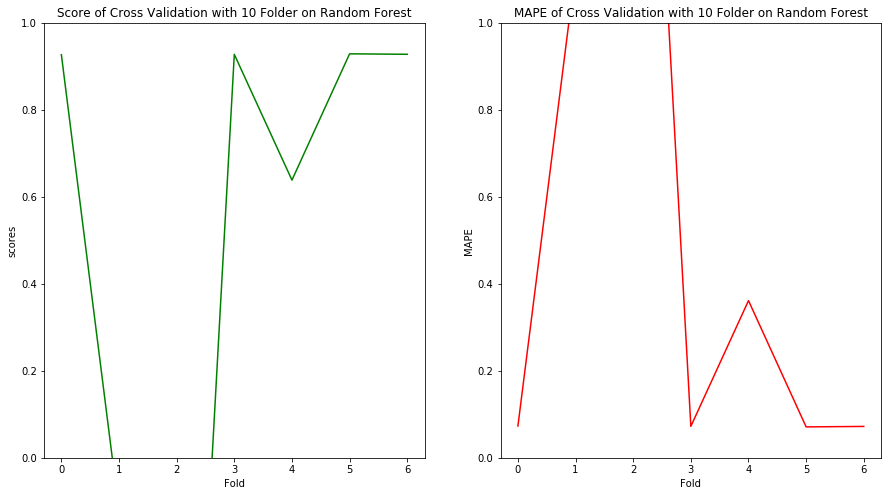

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))
ax = ax.flatten()
ax[0].plot(range(len(scores)), scores, 'g-')
ax[0].set_ylim([0,1])
ax[0].set_ylabel("scores")
ax[0].set_xlabel("Fold")
ax[0].set_title("Score of Cross Validation with 10 Folder on Random Forest")
ax[1].plot(range(len(mapes)), mapes, 'r-')
ax[1].set_ylabel("MAPE")
ax[1].set_xlabel("Fold")
ax[1].set_ylim([0,1])
ax[1].set_title("MAPE of Cross Validation with 10 Folder on Random Forest")
#plt.show()

In [40]:
best_param_cv = {
    'bootstrap': True,
    'max_depth': 80,
    'max_features': 2,
    'min_samples_split': 8,
    'min_samples_leaf': 3,
    'n_estimators': 100
}
rf = RandomForestRegressor(**best_param_cv)
rf.fit(X_train, y_train)
evaluate(rf, X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Model Performance
Accuracy = 99.15%.
MAPE = 0.85%.


99.1521470344252

## LightGBM

In [41]:
import lightgbm as lgb

In [83]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [84]:
train_data = lgb.Dataset(X_train_, label=y_train_)
validation_data = lgb.Dataset(X_val, label=y_val)

In [88]:
param = {
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mape',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'early_stopping_round': 20
}

In [89]:
num_round = 1000
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data], verbose_eval=50)

Training until validation scores don't improve for 20 rounds.
[50]	valid_0's mape: 0.0100077
[100]	valid_0's mape: 0.00931967
[150]	valid_0's mape: 0.00900453
[200]	valid_0's mape: 0.00879923
[250]	valid_0's mape: 0.00867204
[300]	valid_0's mape: 0.00856748
[350]	valid_0's mape: 0.00849853
[400]	valid_0's mape: 0.00842919
[450]	valid_0's mape: 0.00837437
[500]	valid_0's mape: 0.00831462
[550]	valid_0's mape: 0.00826343
[600]	valid_0's mape: 0.00822407
[650]	valid_0's mape: 0.00819653
[700]	valid_0's mape: 0.00816566
[750]	valid_0's mape: 0.00814706
[800]	valid_0's mape: 0.00811676
[850]	valid_0's mape: 0.00809577
[900]	valid_0's mape: 0.00807614
[950]	valid_0's mape: 0.00805252
[1000]	valid_0's mape: 0.00803193
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.00803193


In [90]:
cv_results = lgb.cv(param, train_data, num_round, nfold=5, stratified=False)

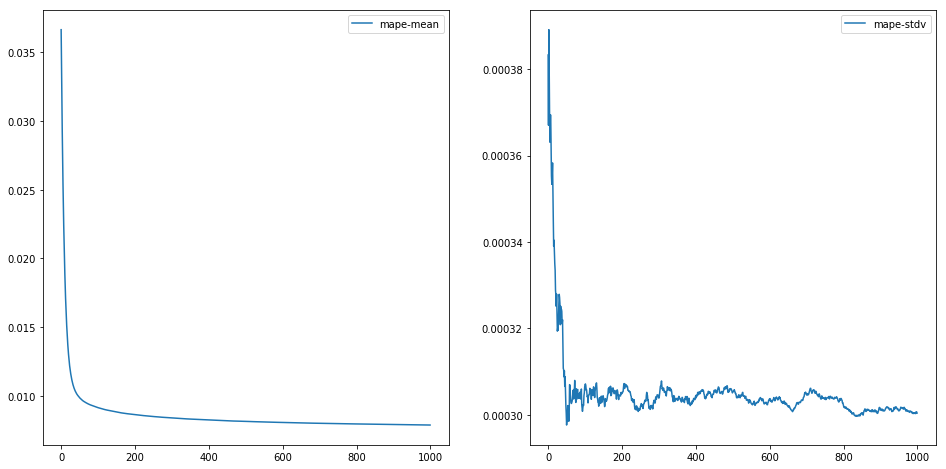

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax = ax.flatten()
ax[0].plot(range(len(cv_results['mape-mean'])), cv_results['mape-mean'], label='mape-mean')
ax[1].plot(range(len(cv_results['mape-stdv'])), cv_results['mape-stdv'], label='mape-stdv')
ax[0].legend()
ax[1].legend()

In [80]:
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
accuracy_score(np.exp(y_test), np.exp(y_pred)), MAPE(np.exp(y_test), np.exp(y_pred))

(0.9277314985241163, 0.07226850147588376)

### Save DataSet

In [96]:
train_data.save_binary(os.path.join(BASE_DIR, 'train.bin'))
validation_data.save_binary(os.path.join(BASE_DIR, 'validation.bin'))

In [93]:
train_data_ = lgb.Dataset(os.path.join(BASE_DIR, 'train.bin'))

In [95]:
train_data_

In [97]:
valid_data = lgb.Dataset(os.path.join(BASE_DIR, 'validation.bin'), reference=train_data_)

In [98]:
valid_data

In [ ]:
gridParams = {
    'learning_rate': [0.1, 0.01, 0.001],
    'num_leaves': [31, 50, 100, 150],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'metric': ['mape'],
    'max_depth': [6],
    'max_bin': [225, 300, 350, 500],
    
}
param = {
    'num_leaves': 31,
    'objective': 'regression',
    'metric': 'mape',
    'max_depth': 6, 
    'learning_rate': 0.1,
    'verbose': 0, 
    'early_stopping_round': 20
}

### Deeply analyst Model

In [187]:
scores = []
mapes = []

folds = defaultdict(list)

cv = KFold(n_splits=7, shuffle=False, random_state=42)

for train_index, val_index in cv.split(X_train):

    X_train_cv, X_val, y_train_cv, y_val = X_train.iloc[train_index, :], \
                                            X_train.iloc[val_index, :], \
                                            y_train[train_index], y_train[val_index]
    # model
    rf_cv = RandomForestRegressor(random_state=42)
    # fit
    rf_cv.fit(X_train_cv, y_train_cv)
    y_val_pred = rf_cv.predict(X_val)
    # add score
    scores.append(accuracy_score(np.exp(y_val), np.exp(y_val_pred)))
    # metric mape
    mapes.append(MAPE(np.exp(y_val), np.exp(y_val_pred)))
    if MAPE(np.exp(y_val), np.exp(y_val_pred)) > 1:
        print(MAPE(np.exp(y_val), np.exp(y_val_pred)))
        folds["X_train_cv"].append(X_train_cv)
        folds["X_val"].append(X_val)
        folds["y_train_cv"].append(y_train_cv)
        folds["y_val"].append(y_val)
        
        

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

2.96778457387575


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [188]:
rf_test = RandomForestRegressor(random_state=42)
rf_test.fit(folds["X_train_cv"][0], folds["y_train_cv"][0])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [190]:
y_val_pred = rf_test.predict(folds["X_val"][0])
print("MAPE: {:.2f}".format(MAPE(np.exp(folds["y_val"][0]), np.exp(y_val_pred))))

MAPE: 2.97


In [191]:
np.mean(np.abs(np.exp(folds["y_val"][0]) - np.exp(y_val_pred))/np.exp(folds["y_val"][0]))

2.96778457387575

In [192]:
np.argmax([np.abs(np.exp(folds["y_val"][0]) - np.exp(y_val_pred))/np.exp(folds["y_val"][0])])

11285

In [195]:
folds["X_val"][0].iloc[11285,:]

Make_                     0.0
Make_a                    1.0
Make_b                    0.0
Make_c                    0.0
Make_d                    1.0
Make_e                    0.0
Make_f                    0.0
Make_g                    0.0
Make_h                    0.0
Make_i                    1.0
Make_j                    0.0
Make_k                    0.0
Make_l                    0.0
Make_m                    0.0
Make_n                    0.0
Make_o                    0.0
Make_p                    0.0
Make_r                    0.0
Make_s                    0.0
Make_t                    0.0
Make_u                    1.0
Make_v                    0.0
Make_w                    0.0
Make_x                    0.0
Make_y                    0.0
Make_z                    0.0
Model_                    0.0
Model_!                   0.0
Model_+                   0.0
Model_-                   0.0
                       ...   
couleur_r                 1.0
couleur_s                 0.0
couleur_t 

In [143]:
np.abs(np.exp(folds["y_val"][0]) - np.exp(y_val_pred))/np.exp(folds["y_val"][0])[4173]

array([ 38.46568067, 206.16817323, 166.63523213, ..., 267.16948689,
       335.71989034, 157.74754807])

In [148]:
len(np.abs(np.exp(folds["y_val"][0]) - np.exp(y_val_pred))/np.exp(folds["y_val"][0]))

13147

In [150]:
np.abs(np.exp(folds["y_val"][0]) - np.exp(y_val_pred))/np.exp(folds["y_val"][0])

array([0.00832951, 0.00776586, 0.01380116, ..., 0.02962953, 0.00924059,
       0.01576057])

In [151]:
a = np.abs(np.exp(folds["y_val"][0]) - np.exp(y_val_pred))/np.exp(folds["y_val"][0]).flatten()

In [154]:
np.argmax(a)

4173

In [155]:
np.max(a)

103.14354562772996

In [153]:
a[4173]

103.14354562772996

## Model Interpreter

In [ ]:
import shap
# Initialize JS For Plot
shap.initjs()

In [ ]:
# Explainer
explainer = shap.TreeExplainer(rfr)

In [ ]:
# calculate shap values for one point testing dataset
shap_values = explainer.shap_values(X_test_imp[0])

In [ ]:
shap_values[0]

In [ ]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:15], X_test.iloc[:15,:])

In [ ]:
shap.force_plot(explainer.expected_value,shap_values[0],X_test.iloc[0,:], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
# Dependence Plot
shap.dependence_plot("age", shap_values,X_test, interaction_index="Model_year")

In [ ]:
shap.dependence_plot("age", shap_values,X_test, interaction_index="Make")

In [ ]:
shap.dependence_plot("Model_year", shap_values,X_test, interaction_index="age")